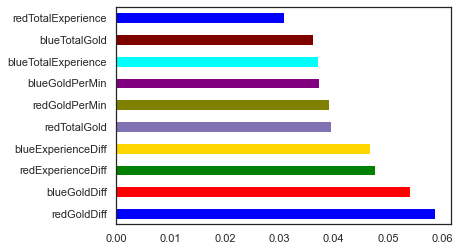

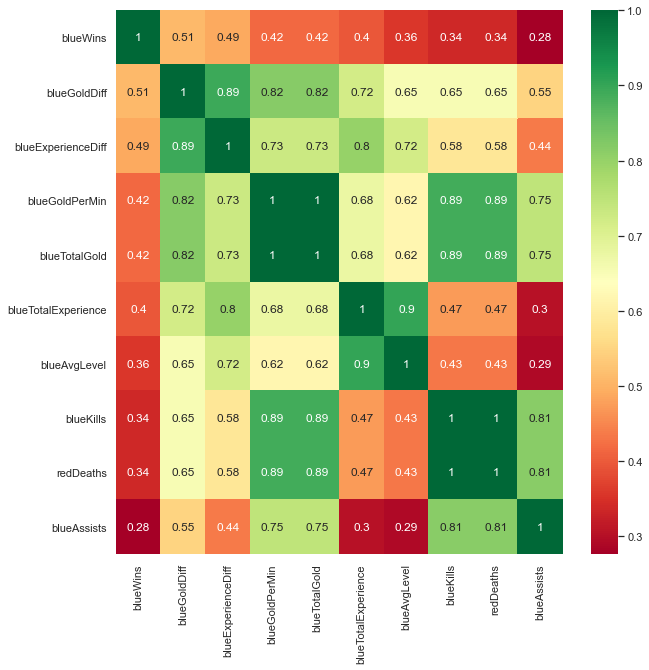

In [19]:
from Data_visualization.Feature_selection import FeatImp,BlueRedSubstraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



data = pd.read_csv('data/lol.csv') 
features = FeatImp(data)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")


sns.set(style='white', context='notebook', palette='deep')

'Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"\nfeaturov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare\ndil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'

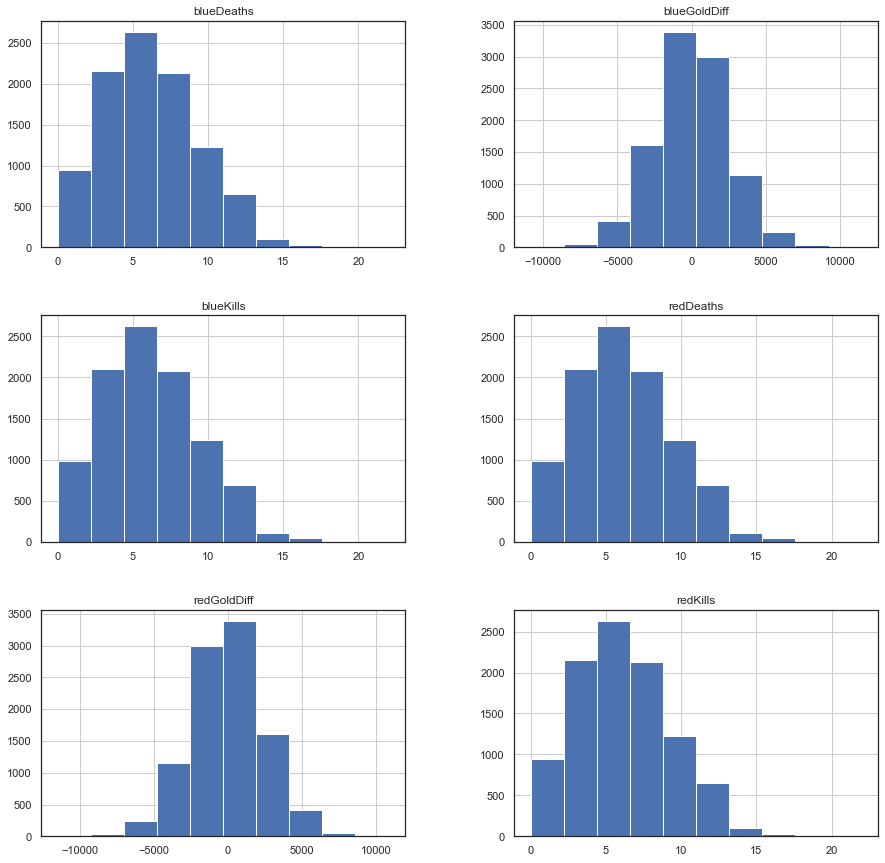

In [20]:
data[['blueKills',
 'redDeaths','redKills','blueDeaths',"blueGoldDiff",'redGoldDiff']].hist(figsize = (15,15))
data_0 = data.drop(['gameId'],axis = 1)
'''Opazim, da  imajo nekateri featuri cisto enake vrednosti ali pa so le nasprotno predznačeni. Menim, da lahko enega izmed "podobnih"
featurov zato zbrišem. Iz podatkov bom izbrisal naslednje feature --> blueDeaths,redDeaths,redGoldDiff,redExpDiff,ampak šele ko bom nare
dil ze nekaj feature inzeniringa. Poleg tega se lahko znebim še gameId, ki ni povezan z nobenim featurom.'''

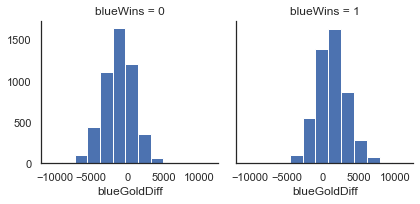

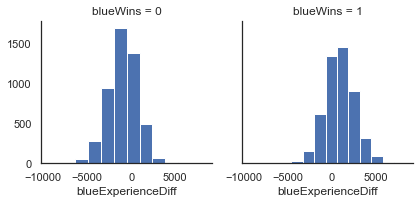

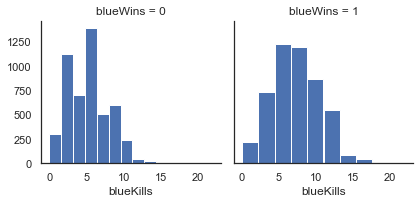

In [13]:
g = sns.FacetGrid(data_0, col='blueWins')
g = g.map(plt.hist,"blueGoldDiff")
g2 = sns.FacetGrid(data_0, col='blueWins')
g2 = g2.map(plt.hist,"blueExperienceDiff")
g3 = sns.FacetGrid(data_0, col='blueWins')
g2 = g3.map(plt.hist,"blueKills")

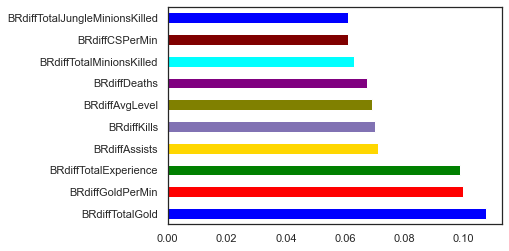

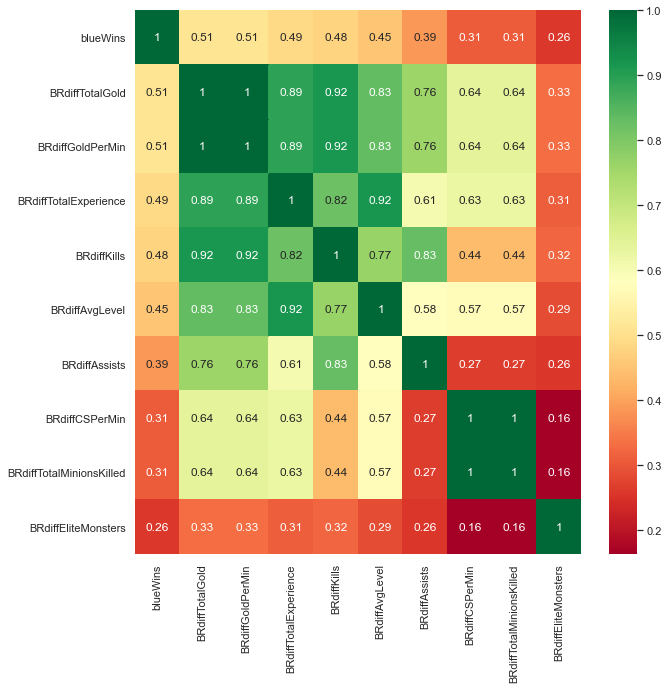

In [21]:
target = data['blueWins']
data_1 = BlueRedSubstraction(data)
data_2 = pd.concat([data_1,target],axis = 1)
features = FeatImp(data_2)
features.tree_selection(target_name = "blueWins")
features.corr_matrix(target_name = "blueWins")
''' Opazim, da imata TotalGold ter GoldPerMin cisto iste korelacije, zato sem šel pogledat vrednosti stolpcev, ter ugotovil da se razlikujeta le
v enem faktorju. Mislim, da se lahko znebim featura GoldPerMin. Enako velja za CSPerMin.'''
data_3 = data_2.drop(["BRdiffGoldPerMin","blueWins","BRdiffCSPerMin"],axis = 1)


In [15]:
data_3.corr()

,BRdiffWardsPlaced,BRdiffWardsDestroyed,BRdiffFirstBlood,BRdiffKills,BRdiffDeaths,BRdiffAssists,BRdiffEliteMonsters,BRdiffDragons,BRdiffHeralds,BRdiffTowersDestroyed,BRdiffTotalGold,BRdiffAvgLevel,BRdiffTotalExperience,BRdiffTotalMinionsKilled,BRdiffTotalJungleMinionsKilled
BRdiffWardsPlaced,1.000000,-0.104968,0.015850,0.031802,-0.031802,0.048836,0.036029,0.032524,0.016782,0.003837,0.024505,0.037614,0.038276,-0.028676,0.004485
BRdiffWardsDestroyed,-0.104968,1.000000,0.045932,0.127299,-0.127299,0.124672,0.053635,0.060369,0.007156,0.030626,0.134564,0.119340,0.123670,0.090088,0.011187
BRdiffFirstBlood,0.015850,0.045932,1.000000,0.366733,-0.366733,0.303375,0.171882,0.149253,0.088875,0.109140,0.378511,0.229811,0.240665,0.199729,0.029866
BRdiffKills,0.031802,0.127299,0.366733,1.000000,-1.000000,0.830751,0.320472,0.281758,0.160520,0.247669,0.917008,0.766222,0.822845,0.435721,0.113480
BRdiffDeaths,-0.031802,-0.127299,-0.366733,-1.000000,1.000000,-0.830751,-0.320472,-0.281758,-0.160520,-0.247669,-0.917008,-0.766222,-0.822845,-0.435721,-0.113480
BRdiffAssists,0.048836,0.124672,0.303375,0.830751,-0.830751,1.000000,0.255418,0.259513,0.075806,0.163933,0.759321,0.580973,0.605836,0.266344,0.032332
BRdiffEliteMonsters,0.036029,0.053635,0.171882,0.320472,-0.320472,0.255418,1.000000,0.834045,0.568232,0.174198,0.329880,0.285370,0.312598,0.163066,0.236691
BRdiffDragons,0.032524,0.060369,0.149253,0.281758,-0.281758,0.259513,0.834045,1.000000,0.019957,0.050436,0.259292,0.226030,0.238264,0.118916,0.203324
BRdiffHeralds,0.016782,0.007156,0.088875,0.160520,-0.160520,0.075806,0.568232,0.019957,1.000000,0.240461,0.211078,0.180027,0.211124,0.118146,0.125674
BRdiffTowersDestroyed,0.003837,0.030626,0.109140,0.247669,-0.247669,0.163933,0.174198,0.050436,0.240461,1.000000,0.404082,0.283992,0.296233,0.261224,0.049858
